# Hand-in 3, Part 2: Data Modeling

In this part you will take the csv file "reduced_field_data.csv" from Part 1, and use it to estimate the line criticality indices.

### Authors:  
Mattias Niels Holm Andersen, S154057  
Kristian Rygaard Svendsen, S153856  
Jakob Will Iversen, S143262

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Score function

Below is a scoring function we have written for you. The output of this function is a score of how well your procedure is doing. Higher scores are worse!

As you can see, it penalizes heavily when you don't predict accurately values when they are being overloaded, i.e. false negatives.


In [2]:
def score_func(y_est, y_real):
    """
        This function takes your estimates y_est and
        scores them against the real data y_real.
        You should use this function to show how good your estimation method is.
    """
    # Square deviation
    sqr_err = np.sum(((y_est - y_real)**2).sum())
    # Penalty for not estimating a critical value above 0.95 when it occurs.
    false_negative = np.sum(np.where(np.logical_and(y_est < 0.95, y_real > 0.95), 10*np.sqrt(np.abs((y_est - y_real))), 0).sum())
    return sqr_err + false_negative

## Load and clean data

Load your data from the previous exercise as well as the criticality data.


In [3]:
# Data is loaded here
fdata = pd.Series()
cdata = pd.Series()
fdata['raw'] = pd.read_csv("reduced_field_data.csv", index_col=0)
cdata['raw'] = pd.read_csv("./Handin3_data/flow_criticality_data.csv", index_col=0)

# check the shape of each dataframe
print('shape of field data:',fdata['raw'].shape)
print('shape of crit data:',cdata['raw'].shape)


shape of field data: (8311, 20)
shape of crit data: (8784, 10)


There are more data in the critical dataset than in the field data.
As the field data has already been cleaned, the focus will be to shape the crit data to match the field data.
First the critical data is checked for N/A's

In [4]:
cdata['raw'].isnull().values.any()

False

As the dataset dosen't contain any N/A values, the data will be sliced based on the time stamps from the field data.

In [5]:
#slicing cdata
indexes = fdata['raw'].index.tolist()
cdata['fixed'] = cdata['raw'].loc[indexes]

# check the shape of each dataframe
print('shape of field data:',fdata['raw'].shape)
print('shape of crit data:',cdata['fixed'].shape)


shape of field data: (8311, 20)
shape of crit data: (8311, 10)


Now the two dataframes have the same amount of rows, and all indexes correspond.

## Linear regression

We have implemented a simple linear regression to apply to your data.
You should use this as a benchmark for your neural network below.


Overall error: 31681.2995


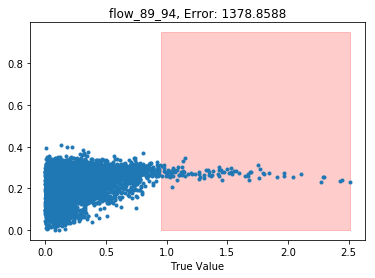

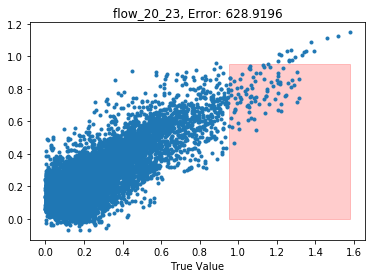

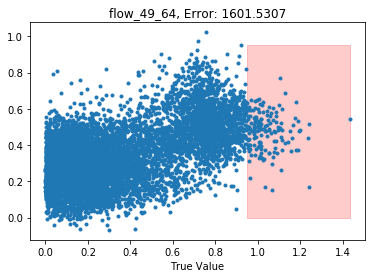

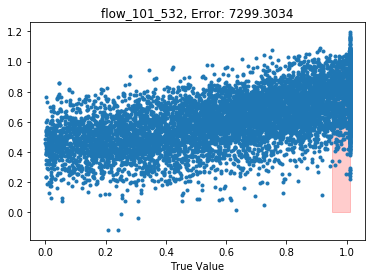

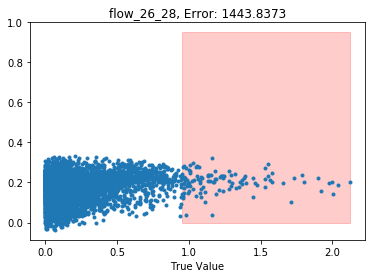

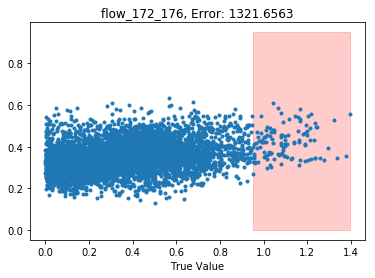

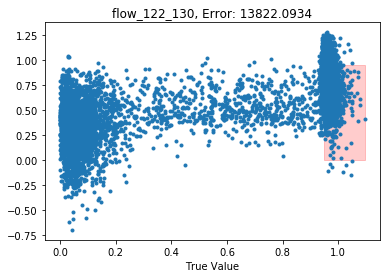

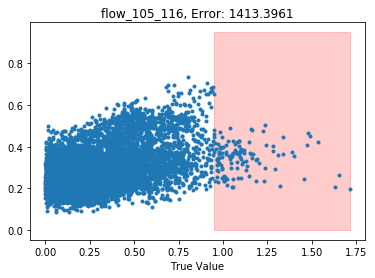

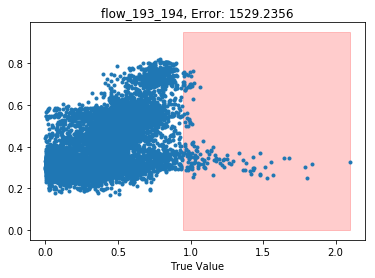

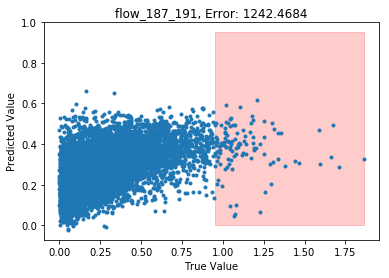

In [6]:
# The code below implements a linear regression on your data and compares predicted and true values.
# On the plots there is a red square indicating the areas corresponding to false negatives.
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(fdata['raw'],cdata['fixed'])

y_pred = lm.predict(fdata['raw'])
for index in range(10):
    plt.figure()
    plt.fill_between([0.95, cdata['fixed'].iloc[:,index].max()], [0.95, 0.95], color='r', alpha=0.2)
    plt.plot(cdata['fixed'].iloc[:,index],y_pred[:,index],'.')
    error = score_func(y_pred[:,index],cdata['fixed'].iloc[:,index])
    plt.title('{0}, Error: {1:.04f}'.format(cdata['fixed'].columns[index], error))
    plt.xlabel('True Value')

plt.ylabel('Predicted Value')
print('Overall error: {0:.04f}'.format(score_func(y_pred, cdata['fixed'])))


**Q#6** Would you recommend using Linear Regression for estimating line criticality indices? Why/why not?


It would not be recomended, as the goal is to predict higher values. By inspecting the graph, it is clear that the model works great at predicting low values, and perform badly at predicting higher values.

This could indicate that the model generally predicts low, and therefor dosen't alarm when a line is close to its maximum capacity. 

# Neural Network

You should now produce a neural network that can estimate criticality indices.
Split your data into a training and test set, build your neural network below, and use the score_func defined above to estimate your model quality.

**Q#7** Explain why you chose the layers, nodes and activation functions you did. (No wrong answers, we want to know your thought process!) What is the best score you can get with a single layer?

The describe function shows that there are no negative values in the y values.

Because of this, a Relu function is chosen as activation function, to ensure we only work with postive values.
As an exception, the output layer is using a sigmoid function. This ensures the final output is somwhere between 0 and 1. The project description says that a value of 1 is very critical, while 0 is not critical.

We have been testing different kind of settings, and ended up with 30 nodes in the first layer and 20 in the second adn 10 in the output layer.  
The output layer is locked to 10, to reflect the y values shape.

With a single layer we got stuck with a score around 60.

In [7]:
cdata['fixed'].describe()

,flow_89_94,flow_20_23,flow_49_64,flow_101_532,flow_26_28,flow_172_176,flow_122_130,flow_105_116,flow_193_194,flow_187_191
count,8311.000000,8311.000000,8311.000000,8311.000000,8311.000000,8311.000000,8311.000000,8311.000000,8311.000000,8311.000000
mean,0.217894,0.275196,0.334282,0.636896,0.154837,0.350944,0.570404,0.295601,0.419396,0.293181
std,0.226315,0.220676,0.286061,0.303014,0.215317,0.216462,0.432059,0.230993,0.254551,0.218237
min,0.000028,0.000057,0.000102,0.000372,0.000000,0.000020,0.000007,0.000022,0.000148,0.000037
25%,0.068596,0.111234,0.099745,0.395367,0.024856,0.186310,0.065874,0.114807,0.203332,0.135694
50%,0.148285,0.223058,0.230912,0.683397,0.078842,0.337684,0.939943,0.245012,0.420071,0.248494
75%,0.296776,0.381701,0.560253,0.912150,0.187546,0.470470,0.959595,0.425991,0.600866,0.397962
max,2.509490,1.578194,1.432856,1.010000,2.121284,1.394635,1.094027,1.713256,2.097648,1.862794


In [8]:
# Split data into training and test
# creating train data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(fdata['raw'],
                                                    cdata['fixed'], 
                                                    test_size=0.1)


In [9]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers

# creating model object
model = Sequential()

# adding layers
model.add(Dense(30, activation='relu', input_dim=X_train.shape[1],))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='sigmoid'))

# tweaking settings
adam = optimizers.Adam(lr=0.001, beta_1=0.9,
beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])

# fitting model
history = model.fit(X_train.values,y_train.values, validation_data=(X_test.values,y_test.values),
epochs = 80, batch_size=100, shuffle=False)
y_pred = model.predict(X_test.values, batch_size = 1000)

Using TensorFlow backend.


Train on 7479 samples, validate on 832 samples
Epoch 1/80
7479/7479 [==============================] - 0s - loss: 0.2769 - acc: 0.1174 - val_loss: 0.2519 - val_acc: 0.1406
Epoch 2/80
7479/7479 [==============================] - 0s - loss: 0.2109 - acc: 0.1956 - val_loss: 0.1642 - val_acc: 0.2764
Epoch 3/80
7479/7479 [==============================] - 0s - loss: 0.1588 - acc: 0.3158 - val_loss: 0.1589 - val_acc: 0.2788
Epoch 4/80
7479/7479 [==============================] - 0s - loss: 0.1583 - acc: 0.3069 - val_loss: 0.1600 - val_acc: 0.2825
Epoch 5/80
7479/7479 [==============================] - 0s - loss: 0.1566 - acc: 0.3185 - val_loss: 0.1587 - val_acc: 0.2788
Epoch 6/80
7479/7479 [==============================] - 0s - loss: 0.1545 - acc: 0.3145 - val_loss: 0.1575 - val_acc: 0.2825
Epoch 7/80
7479/7479 [==============================] - 0s - loss: 0.1536 - acc: 0.3288 - val_loss: 0.1542 - val_acc: 0.3101
Epoch 8/80
7479/7479 [==============================] - 0s - loss: 0.1516 - ac

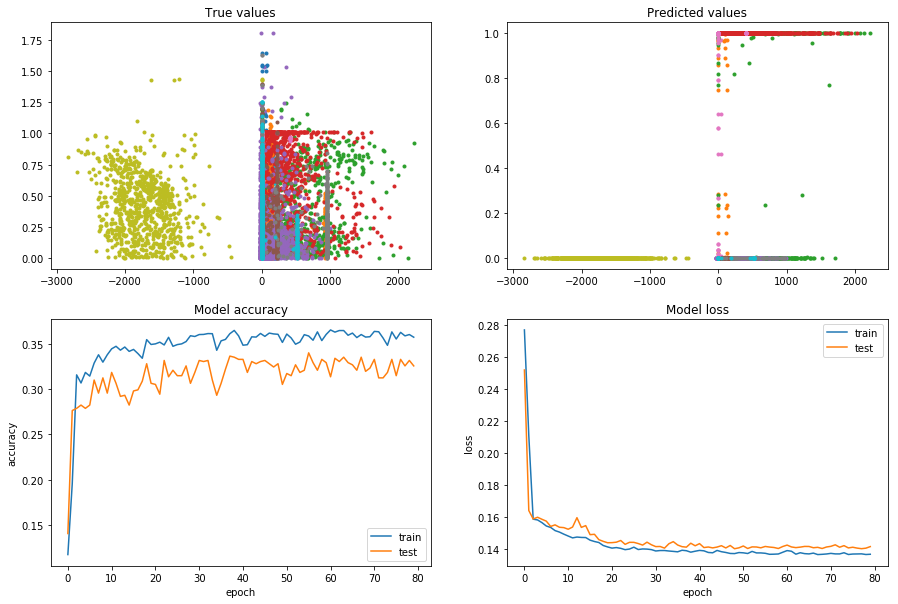

In [10]:
# true values plot
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(X_test,y_test, ls='', marker='.');
plt.title('True values');

# predicted values plotb
plt.subplot(2,2,2)
plt.plot(X_test,y_pred, ls='', marker='.');
plt.title('Predicted values');

# Visualize accuracy performance
plt.subplot(2,2,3)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')


# Visualize loss performance (MSE)
plt.subplot(2,2,4)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()


The model predicts all negative sensor values as non critical. The true values plot, in contrast, shows there are in fact some critical values in the negative spectrum.  
When the values goes into the positive side, there are alot of critical predictions, and also many 0 predictions.
There generally isn't alot of values predicted in between.  
The model accuracy plot shows the accuracy of the model in each epoch iteration. In contrast the model loss(mean squared error) shows the loss in each epoch.

# K-fold cross validation

To ensure that your neural network actually works when presented with new data, take the neural network you defined above, and perform a k-fold cross validation on it.

**Q#8** Using a test window size of one tenth of your data (ten-fold cross validation), plot a histogram of the output of score_func for the validation. Tweak your neural network to achieve the lowest mean score.

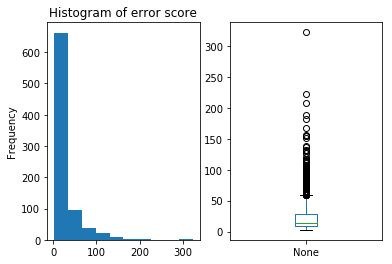

mean score:		25.75
mean false negatives:	11.61
mean positives:		66.97


In [11]:
# Your k-fold code goes here.
from sklearn.model_selection import KFold

#a pandas series to hold the scores
score = []
falseNegatives = []
positives = []

#X and Y are created as pandas series
X = pd.Series(fdata['raw'].index.tolist())
y = pd.Series(cdata['fixed'].index.tolist())

# Splitting
kf = KFold(int(X.size/10))
kf.get_n_splits(X)

for train_index, test_index in kf.split(X):
    # creating test and train set
    X_train, X_test = fdata['raw'].loc[X.iloc[train_index]], fdata['raw'].loc[X.iloc[test_index]]
    y_train, y_test = cdata['fixed'].loc[X.iloc[train_index]], cdata['fixed'].loc[X.iloc[test_index]]
    
    #predicting new values
    y_pred = model.predict(X_test.values, batch_size = 1000)
    
    # evaluating result
    score.append(score_func(y_pred, y_test))
    falseNegatives.append(np.sum(np.where(np.logical_and(y_pred < 0.95, y_test > 0.95))))
    positives.append(np.sum(np.where(y_test > 0.95)))
    
    
# creating pandas series
Score = pd.Series(score)
FalseNegatives = pd.Series(falseNegatives)
Positives = pd.Series(positives)

# printing histogram and mean score
#plt.figure(figsize=(10,10))
plt.subplot(121)
Score.plot.hist()
plt.title('Histogram of error score');
plt.subplot(122)
Score.plot.box()
plt.show()
print('mean score:\t\t{:.2f}'.format(Score.mean()))
print('mean false negatives:\t{:.2f}'.format(FalseNegatives.mean()))
print('mean positives:\t\t{:.2f}'.format(Positives.mean()))

**Q#9** Are you satisfied with the quality of the final estimator? What would be your recommendation for your boss on this issue?

The result is alot better than for the linear regression.  
We should keep in mind that the linear regression score is expected to be alot higher, because it is made from the entire dataset, thus alot more potentially false negatives.  
We see that we get a very low score, and only 16% percent of the critical values are estimated too low.  
This seems like a viable solution, depending on how much error the boss is willing to accept.

# Extra task for 3-person groups

**Q#10** Repeat the process, once reducing to 15 sensors, and once reducing to 25 sensors. The costs to keep these sensors running is directly proportional to the number of sensors used. Does changing the number of sensors used change your conclusion in Q#9?

All networks show the same performance. Our recomendation is to use 15 sensor to minimize expenses.

In [12]:
#loading new field data
fdata15 = pd.read_csv("reduced_field_15_data.csv", index_col=0)
fdata25 = pd.read_csv("reduced_field_25_data.csv", index_col=0)

In [13]:
# Training network with 15 sensors

# Split data into training and test
# creating train data
X_train, X_test, y_train, y_test = train_test_split(fdata15,
                                                    cdata['fixed'], 
                                                    test_size=0.1)




# training model
model15 = Sequential()
model15.add(Dense(30, activation='relu', input_dim=X_train.shape[1],))
model15.add(Dense(20, activation='relu'))
model15.add(Dense(10, activation='sigmoid'))

adam = optimizers.Adam(lr=0.005, beta_1=0.9,
beta_2=0.999, epsilon=1e-08, decay=0.0)
model15.compile(loss='mean_squared_error', optimizer=adam)
model15.fit(X_train.values,y_train.values,
epochs = 80, batch_size=100, shuffle=False)

Epoch 1/80
7479/7479 [==============================] - 0s - loss: 0.2115     
Epoch 2/80
7479/7479 [==============================] - 0s - loss: 0.1868     
Epoch 3/80
7479/7479 [==============================] - 0s - loss: 0.1819     
Epoch 4/80
7479/7479 [==============================] - 0s - loss: 0.1815     
Epoch 5/80
7479/7479 [==============================] - 0s - loss: 0.1802     
Epoch 6/80
7479/7479 [==============================] - 0s - loss: 0.1811     
Epoch 7/80
7479/7479 [==============================] - 0s - loss: 0.1786     
Epoch 8/80
7479/7479 [==============================] - 0s - loss: 0.1782     
Epoch 9/80
7479/7479 [==============================] - 0s - loss: 0.1805     
Epoch 10/80
7479/7479 [==============================] - 0s - loss: 0.1769     
Epoch 11/80
7479/7479 [==============================] - 0s - loss: 0.1795     
Epoch 12/80
7479/7479 [==============================] - 0s - loss: 0.1780     
Epoch 13/80
7479/7479 [==========================

In [14]:
# Training network with 25 sensors

# Split data into training and test
# creating train data
X_train, X_test, y_train, y_test = train_test_split(fdata25,
                                                    cdata['fixed'], 
                                                    test_size=0.1)
# training model
model25 = Sequential()
model25.add(Dense(30, activation='relu', input_dim=X_train.shape[1],))
model25.add(Dense(20, activation='relu'))
model25.add(Dense(10, activation='sigmoid'))

adam = optimizers.Adam(lr=0.005, beta_1=0.9,
beta_2=0.999, epsilon=1e-08, decay=0.0)
model25.compile(loss='mean_squared_error', optimizer=adam)
model25.fit(X_train.values,y_train.values,
epochs = 80, batch_size=100, shuffle=False)

Epoch 1/80
7479/7479 [==============================] - 0s - loss: 0.2353     
Epoch 2/80
7479/7479 [==============================] - 0s - loss: 0.2327     
Epoch 3/80
7479/7479 [==============================] - 0s - loss: 0.2327     
Epoch 4/80
7479/7479 [==============================] - 0s - loss: 0.2327     
Epoch 5/80
7479/7479 [==============================] - 0s - loss: 0.2327     
Epoch 6/80
7479/7479 [==============================] - 0s - loss: 0.2327     
Epoch 7/80
7479/7479 [==============================] - 0s - loss: 0.2327     
Epoch 8/80
7479/7479 [==============================] - 0s - loss: 0.2327     
Epoch 9/80
7479/7479 [==============================] - 0s - loss: 0.2327     
Epoch 10/80
7479/7479 [==============================] - 0s - loss: 0.2327     
Epoch 11/80
7479/7479 [==============================] - 0s - loss: 0.2327     
Epoch 12/80
7479/7479 [==============================] - 0s - loss: 0.2327     
Epoch 13/80
7479/7479 [==========================

Now that the two nerual networks have been trained, cross validation will be performed on the three networks, and their performance evaluated.

In [15]:

# evaluating 15 sensor netwror
#a pandas series to hold the scores
score15 = []

#X and Y are created as pandas series
X = pd.Series(fdata15.index.tolist())
y = pd.Series(cdata['fixed'].index.tolist())

# Splitting
kf = KFold(int(X.size/10))
kf.get_n_splits(X)

for train_index, test_index in kf.split(X):
    # creating test and train set
    X_train, X_test = fdata15.loc[X.iloc[train_index]], fdata15.loc[X.iloc[test_index]]
    y_train, y_test = cdata['fixed'].loc[X.iloc[train_index]], cdata['fixed'].loc[X.iloc[test_index]]
    
    #predicting new values
    y_pred = model15.predict(X_test.values, batch_size = 1000)
    
    # evaluating result
    score15.append(score_func(y_pred, y_test))
    

# creating pandas series
Score15 = pd.Series(score)



#evaluating 20 sensor network
# evaluating 15 sensor netwror
#a pandas series to hold the scores
score20 = []

#X and Y are created as pandas series
X = pd.Series(fdata['raw'].index.tolist())
y = pd.Series(cdata['fixed'].index.tolist())

# Splitting
kf = KFold(int(X.size/10))
kf.get_n_splits(X)

for train_index, test_index in kf.split(X):
    # creating test and train set
    X_train, X_test = fdata['raw'].loc[X.iloc[train_index]], fdata['raw'].loc[X.iloc[test_index]]
    y_train, y_test = cdata['fixed'].loc[X.iloc[train_index]], cdata['fixed'].loc[X.iloc[test_index]]
    
    #predicting new values
    y_pred = model.predict(X_test.values, batch_size = 1000)
    
    # evaluating result
    score20.append(score_func(y_pred, y_test))
    

# creating pandas series
Score20 = pd.Series(score)



# evaluating 25 sensor netwror
#a pandas series to hold the scores
score25 = []

#X and Y are created as pandas series
X = pd.Series(fdata25.index.tolist())
y = pd.Series(cdata['fixed'].index.tolist())

# Splitting
kf = KFold(int(X.size/10))
kf.get_n_splits(X)

for train_index, test_index in kf.split(X):
    # creating test and train set
    X_train, X_test = fdata25.loc[X.iloc[train_index]], fdata25.loc[X.iloc[test_index]]
    y_train, y_test = cdata['fixed'].loc[X.iloc[train_index]], cdata['fixed'].loc[X.iloc[test_index]]
    
    
    #predicting new values
    y_pred = model25.predict(X_test.values, batch_size = 1000)
    
    # evaluating result
    score25.append(score_func(y_pred, y_test))
    

# creating pandas series
Score25 = pd.Series(score)

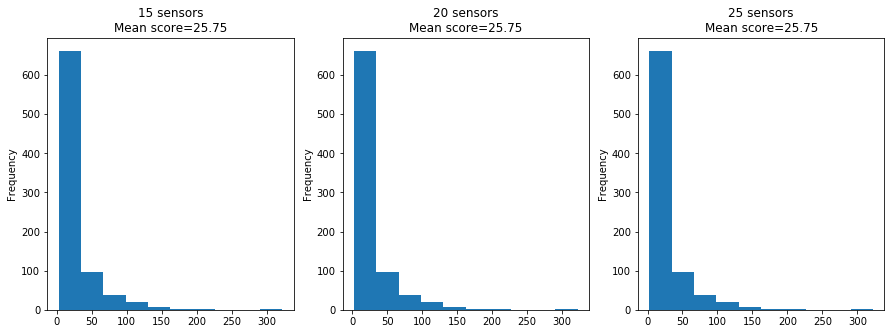

In [16]:
#plotting and evaluating result
# printing histogram and mean score
plt.figure(figsize=(15,5))
plt.subplot(131)
Score15.plot.hist()
plt.title('15 sensors\nMean score={:.2f}'.format(Score15.mean()))

# printing histogram and mean score
plt.subplot(132)
Score20.plot.hist()
plt.title('20 sensors\nMean score={:.2f}'.format(Score20.mean()))

# printing histogram and mean score
plt.subplot(133)
Score25.plot.hist()
plt.title('25 sensors\nMean score={:.2f}'.format(Score25.mean()))
plt.show()

The results look exactly alike. This is a very suprising result, but as the price of a sensor is quite high, a very fortunate result.